# Imports

In [1]:
from typing import TypeVar, Generic, List
from tqdm import trange
import numpy as np
from abc import ABC, abstractmethod
from matplotlib import pyplot as plt

T = TypeVar("T")

from IPython.core.pylabtools import figsize

figsize(20, 5)

# MetropolisHastings ABC

In [2]:
class AbstractMetropolisHastings(ABC, Generic[T]):
    def __init__(self, initial_configuration: T):
        self.configuration_history: List[T] = [
            initial_configuration
        ]  # This array evolves over time :D
        self.accepted_configuration_count: int = 0
        self.rejected_configuration_count: int = 0

    @property
    def current_configuration(self) -> T:
        return self.configuration_history[-1]

    @abstractmethod
    def generator_function(self) -> T:
        pass

    @abstractmethod
    def approval_function(self, new_configuration: T) -> bool:
        pass

    def run_single_iteration(self, limit_tries=10**5) -> T:
        tries = 0
        while True:
            new_state = self.generator_function()
            if self.approval_function(new_state):
                self.configuration_history.append(new_state)
                self.accepted_configuration_count += 1
                return new_state

            self.rejected_configuration_count += 1
            tries += 1
            if tries >= limit_tries:
                # Useful for debugging
                tries = 0
                limit_tries *= int(1.1)
                print(f"{new_state:e}", end=", ")

    def run_iterations(self, n: int) -> None:
        pbar = trange(n, desc="Bar desc", leave=True)
        for _ in pbar:
            self.run_single_iteration()
            if (
                self.accepted_configuration_count + self.rejected_configuration_count
            ) % 10**3 == 0:
                pbar.set_description(
                    f"({self.rejected_configuration_count}/{self.accepted_configuration_count  +self.rejected_configuration_count}) {self.current_configuration:e} ",
                    refresh=True,
                )

    def plot(self) -> None:
        plt.plot(self.configuration_history)

## Applied to VMC

The goal of this section is to calculate $\int ... dR $

$$
\left \{
\begin{array}{rll}
H &= - \frac{\partial^2}{2 \partial x^2} +V(x) & \text{Hamiltonian}\\
\psi(R) &= \exp({-p_0(x-p_1)^2-p_2(x-p_3)^2}) & \text{Wave function}\\
E_L(R) &= \frac{H\psi(R)}{\psi(R)} = V(x) - \frac{1}{2}\frac{\partial^2}{\partial x^2}\psi(x) & \text{"Local" energy}\\
V(x) &= \frac{a_2}{2}x^2 + a_4x^4 & \text{Potential energy}\\
G(R,R', \beta) &= \braket{R | e^{- \beta H} | R'} & \text{???}\\
\Pi(R) &\propto | \psi(R) |^2 & \text{Sampling probability???}\\
\end{array}
\right .
$$

In [3]:
class VMC(AbstractMetropolisHastings[float]):
    a = [1, 0]
    p = [2, 0, 0, 0]
    sigma = 0.5

    def generator_function(self):
        return self.current_configuration + np.random.normal(0, self.sigma)

    def approval_function(self, new_configuration):

        p = self.p
        amplitude_calculator = lambda x: np.prod(
            [-1, p[0], x - p[1], x - p[1]]
        ) + np.prod([-1, p[2], x - p[3], x - p[3]])
        logged_old_amplitude = amplitude_calculator(self.current_configuration)
        logged_new_amplitude = amplitude_calculator(new_configuration)
        return 2 * (logged_old_amplitude - logged_new_amplitude) <= np.log(
            np.random.random()
        )

In [4]:
vmc = VMC(initial_configuration=10**5)

In [5]:
vmc.run_iterations(10**5)

(99418/199000) 6.026289e+04 : 100%|██████████| 100000/100000 [00:03<00:00, 25957.24it/s]


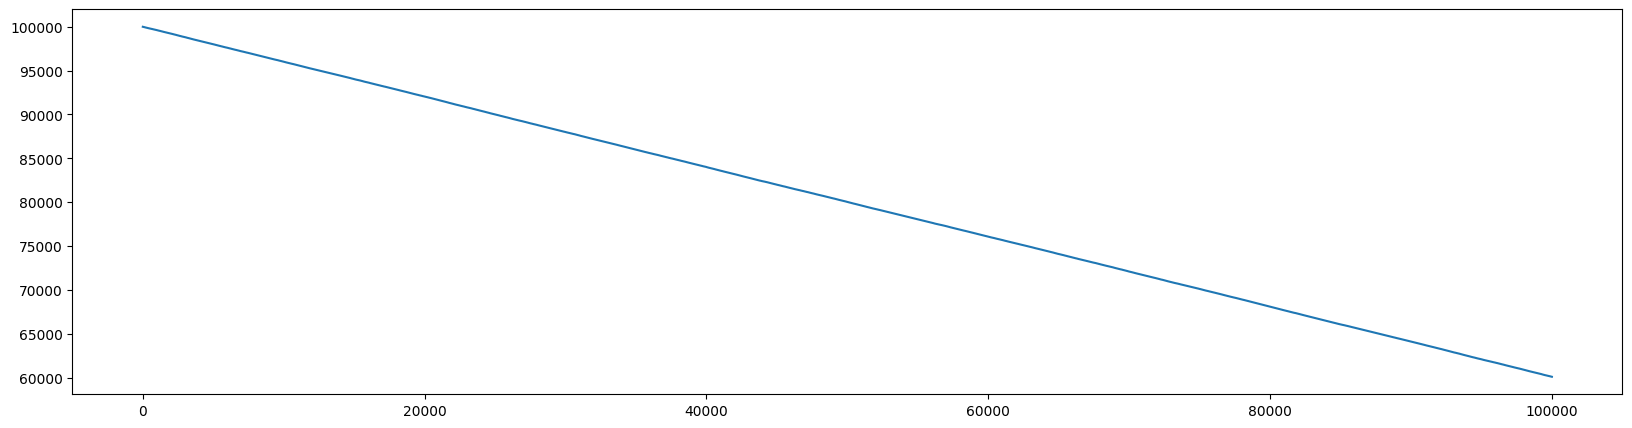

In [6]:
vmc.plot()